In [1]:
import csv
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI 
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
from collections import Counter
import igraph as ig
import pandas as pd
import numpy as np
import csv

from collections import Counter
from scipy.stats import binom 
from statistics import mean 
import seaborn as sns
import matplotlib.pyplot as plt

hnx.__version__

'2.3.5'

## Visualisation functions

In [2]:
def edge_statistics(edges_file):
    with open(edges_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))
    sizes = [len(Edges[i]) for i in range(len(Edges))]
    ctr_sizes = Counter(sizes)
    print("EDGE STATISTICS:")
    print("Mean size:",mean(sizes))
    print("Sizes counter:",dict(ctr_sizes))
    df = pd.DataFrame(sizes)
    df.columns = ['size']
    plt.figure(figsize=(9,4))
    sns.countplot(x = "size", data = df)
    plt.show()

def comm_statistics(comm_file):
    with open(comm_file, 'r') as file:
        gt = [int(line) for line in file]
        A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]

    print("COMMUNITIES STATISTICS:")
    community_sizes = [len(A_gt[i]) for i in range(len(A_gt))]
    print("Number of communities", len(A_gt))
    print("Mean size:", mean(community_sizes), "min size:", min(community_sizes), "max size:", max(community_sizes) )
    print("Sizes", community_sizes)
    
    
def edges_in_ground_truth_community(edge_file,partitions, show_aggr = 1, show_edge_sizes = 'all', edge_sizes_to_show = {}):
    print("")
    print("EDGES IN A GROUND-TRUTH COMMUNITY")
    with open(comm_file, 'r') as file:
        gt = [int(line) for line in file]
        A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]
    with open(edge_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))

    edge_comm = []    
    for e in Edges:
        size = len(e)
        biggest = Counter([gt[int(i)-1] for i in e]).most_common(1)[0][1]
        edge_comm.append({'size': size, 'biggest': biggest, 'ratio': biggest/size})


    to_display = {}
    to_display["lambda"] = []
    xs = np.linspace(0.501,1, 500)
    for x in xs:
        to_display["lambda"].append(x)
        
    if show_aggr == 1:
        to_display["aggr"] = []
    edges2show = []
        
    if show_edge_sizes == 'all':
        edges2show = list(set([len(e) for e in Edges]))
    else:
        edges2show = list(edge_sizes_to_show)  
        
    edges2show = sorted(edges2show)
        
        
    for i in edges2show:
        to_display[i] = []

    for x in xs:
        to_display["aggr"].append(sum(list(a["ratio"]>=x for a in edge_comm)))

    for i in edges2show:
        for x in xs:
            to_display[i].append(sum(list(a["ratio"]>=x and a["size"]==i for a in edge_comm)))

    plt.figure(figsize=(9,5))
    plt.ylim(0, to_display["aggr"][0]+50)
    
    plt.title("Number of edges captured by the partition")
    plt.xlabel("Percentage of nodes in the edge")
    plt.ylabel("Number of edges")
    df = pd.DataFrame(to_display)  
    if show_aggr == 1:
        sns.lineplot(data=df, x = "lambda", y = "aggr", label = "all sizes")
    
    for i in edges2show:
        sns.lineplot(data=df, x = "lambda", y = i, label = "size "+str(i))
        
    plt.show()
    return df, edge_comm



    
    
    #return 0
    
def visualise_case(edge_file,comm_file, show_aggr = 1, show_edge_sizes = 'all', edge_sizes_to_show = {}):
    edge_statistics(edge_file)
    comm_statistics(comm_file)
    df = edges_in_ground_truth_community(edge_file,comm_file, show_aggr=show_aggr,
                           show_edge_sizes = show_edge_sizes, edge_sizes_to_show = edge_sizes_to_show)
    return df

## Loading the graph

In [3]:
def load_ABCDH_from_file(filename):
    with open(filename,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(list(line))

    HG = hnx.Hypergraph(dict(enumerate(Edges)))
    return HG

In [4]:
HG = load_ABCDH_from_file("datasets/results_300_he.txt")
## julia --project abcdh.jl -n 300 -d 2.5,5,20 -c 1.5,10,30 -x 0.3 -q 0.0,0.4,0.3,0.2,0.1 -w :linear -s 1234 --stats -o results_300




EDGE STATISTICS:
Mean size: 2.641053787047201
Sizes counter: {2: 515, 3: 245, 4: 114, 5: 37}


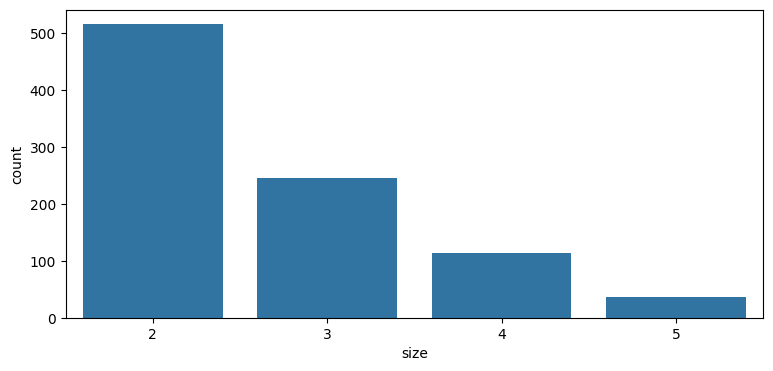

COMMUNITIES STATISTICS:
Number of communities 18
Mean size: 16.666666666666668 min size: 10 max size: 28
Sizes [28, 25, 25, 22, 22, 19, 18, 15, 15, 14, 14, 14, 13, 12, 12, 11, 11, 10]

EDGES IN A GROUND-TRUTH COMMUNITY


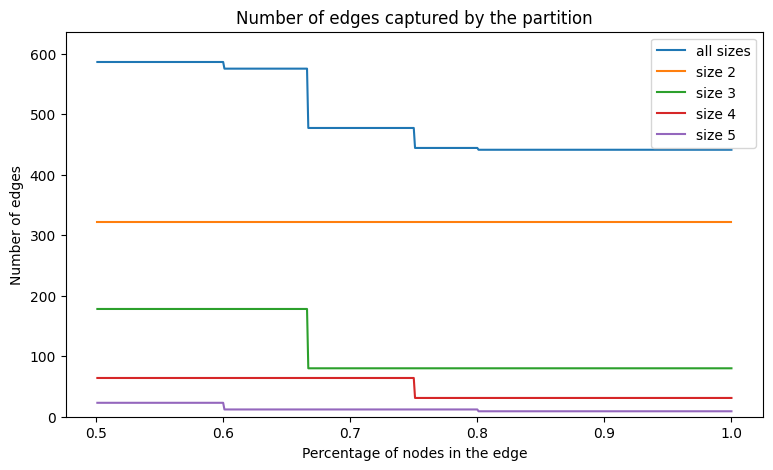

In [5]:
comm_file = "datasets/results_300_assign.txt"
edge_file = "datasets/results_300_he.txt"

print("")
df = visualise_case(edge_file,comm_file)

## Examples o usage

In [6]:
import h_louvain as hl
from h_louvain_BO import hLouvainBO

In [7]:
hL = hl.hLouvain(HG,hmod_tau=1, resolution = 1, 
                                    random_seed = 8771) 

### hLouvain without last steps (any)

In [8]:
%%time
#### No forcing alpha = 1 at the end

alphas = []
c = 0.3
b = 0.8
for i in range(30):
    alphas.append(1-((1-b)**i))

A, q2, alphas_out = hL.h_louvain_community(alphas = alphas, force_alpha_1 = False,
                                                change_frequency=c)
qH = hL.combined_modularity(A, alpha = 1, hmod_tau = 1, resolution =1)

print("alphas_out", alphas_out)

print("qH =",qH)
print("final partition size",len(A))

alphas_out [0.0, 0.8, 0.96]
qH = 0.530150847058162
final partition size 15
CPU times: user 1.08 s, sys: 5.05 ms, total: 1.08 s
Wall time: 1.08 s


### hLouvain with cheap last step (default)

In [9]:
%%time
## default value force_alpha_1 = True

alphas = []
c = 0.3
b = 0.8
for i in range(30):
    alphas.append(1-((1-b)**i))

A, q2, alphas_out = hL.h_louvain_community(alphas = alphas, change_frequency=c)
qH = hL.combined_modularity(A, alpha = 1, hmod_tau = 1, resolution =1)


print("alphas_out", alphas_out)

print("qH =",qH)
print("final partition size",len(A))

alphas_out [0.0, 0.8, 0.96, 1]
qH = 0.530150847058162
final partition size 15
CPU times: user 589 ms, sys: 4.1 ms, total: 593 ms
Wall time: 591 ms


In [10]:
%%time
Als, A, qls, qH, alphas_out = hL.h_louvain_community_plus_last_step(alphas = alphas, change_frequency=c)
qH = hL.combined_modularity(A, alpha = 1, hmod_tau = 1, resolution =1)
qHls = hL.combined_modularity(Als, alpha = 1, hmod_tau = 1, resolution =1)

print("alphas_out", alphas_out)
print("gH (before last step) =",qH)
print("before last step partition size",len(A))
print("gH (after last step) =",qHls)
print("final partition size",len(Als))

alphas_out [0.0, 0.8, 0.96, 1]
gH (before last step) = 0.530150847058162
before last step partition size 15
gH (after last step) = 0.5325816464803007
final partition size 15
CPU times: user 4.89 s, sys: 28.4 ms, total: 4.92 s
Wall time: 4.89 s


## hLouvainBO examples

In [11]:
hBO = hLouvainBO(HG,hmod_tau=1,resolution =1,  
                                    random_seed = 8771) 



Parameters for hBO.set_params
----------

- seeds : array of integers, optional, default = [1234,5325,5467,4723,999,989,1245, 432,1904,7633]
    
The bayesian optimization target function is a mean of hLouvain algoritm executions for seeds taken from this array.
The length of the array is crucial to control the number of execution.

- xi : float, optional, default = 1e-3
    
The parameter for bayesian optimization, which controls exploration vs exploitation trade off

- init_points : int, optional, default = 5
    
The number of initial points (b,c) for bayesian optimization

- n_iter : int, optional, default = 5
    
The number of search points for bayesian optimization (bayesian optimization iterations)

- pbounds : dict, default = {'b': (0,1), 'c': (0.01,0.99)}
    
Parameter bounds for b and c

- bomode : str, default = "last_step"
    
The version of hLouvain bayesian optimization.
The default "last_step" assumes performing the last step optimization only for several best results of core bayesian optimization output.
    
- Other options: 
    
"basic" : no last step, 
"last_step_all" - performing last step optimization for every execution (not recommended for big networks)

- last_step_top_points : int, optional, default = 1
    
The parameter used for bomode = "last_step". 
The number of best results for which the last step optimization is performed.

- show_bo_table  : boolean, optional, default = True
    
When set True the bayesian optimization table is presented

- given_points : list of dicts, optional, default = []
    
The points forced to be checked as additional init points for bayesian optimization 
E.g., given points = [{"b": 0.8, "c": 0.2}, {"b": 0.9, "c": 0.3}]
   

In [12]:
hBO.set_params(bomode="last_step", last_step_top_points = 1)
result_df = hBO.hLouvain_perform_BO()


|   iter    |  target   |     b     |     c     |
-------------------------------------------------
| 1         | 0.5228    | 0.1476    | 0.5427    |
| 2         | 0.5207    | 0.003355  | 0.1489    |
| 3         | 0.5255    | 0.7225    | 0.3788    |
| 4         | 0.5233    | 0.1622    | 0.5052    |
| 5         | 0.5216    | 0.7788    | 0.05543   |
| 6         | 0.5234    | 0.9365    | 0.2221    |
| 7         | 0.5249    | 0.8074    | 0.426     |
| 8         | 0.5257    | 0.6429    | 0.4837    |
| 9         | 0.5251    | 0.489     | 0.3897    |
| 10        | 0.5251    | 0.7188    | 0.3812    |


In [13]:
result_df

,b,c,seed,#com,qH,alphas,A,A_lstep,qH_lstep
81,0.489044,0.389676,5325,15,0.531342,"[0.0, 0.48904444844422723, 0.738924424334336, ...","[{122, 206, 94, 53, 60, 24, 195, 222, 175, 235...","[{122, 206, 94, 53, 60, 195, 24, 222, 175, 235...",0.533565


In [14]:
print("qH (before last step):",result_df["qH"].iloc[0])
print("qH (final - after last step):",result_df["qH_lstep"].iloc[0])
print("partition size - final:",len(result_df["A_lstep"].iloc[0]))

qH (before last step): 0.5313418940914605
qH (final - after last step): 0.5335653627000675
partition size - final: 15


### Checking AMI and ARI

In [15]:
def getAMI_ARI(HG,gt,A):
    d = hmod.part2dict(A)
    A4ari = [d[str(i+1)] for i in range(len(HG.nodes))]
    return AMI(gt, A4ari), ARI(gt, A4ari)

In [21]:
# 2-section iGraph

G = hmod.two_section(HG)
G.vs['louvain'] = G.community_multilevel(weights='weight').membership
ML = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})

with open(comm_file, 'r') as file:
    gt = [int(line) for line in file]
A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]



print("2-section (ML) (AMI,ARI):", getAMI_ARI(HG,gt,ML),"no of com", len(ML))
print("modularity", hL.combined_modularity(ML, alpha = 1, hmod_tau = 1, resolution =1))

2-section (ML) (AMI,ARI): (0.8778070951451996, 0.7687929590387341) no of com 14
modularity 0.5225418972108877


### check for hLouvainBO best

In [18]:
sorted_results = result_df.sort_values(by = ["qH_lstep"],  ascending=False)
best_A = sorted_results["A_lstep"].tolist()

for i in range(hBO.last_step_top_points):
    print("linear (AMI,ARI):", getAMI_ARI(HG,gt,best_A[i]),"no of com", len(best_A[i]))

linear (AMI,ARI): (0.8260996087615211, 0.7197860349750446) no of com 15


In [19]:
## different tau check

In [20]:
for tau in [0,1,1.5,2,2.5,3,3.5,4,"infinity"]:
    hBO = hLouvainBO(HG,hmod_tau=tau,resolution =1,  
                                    random_seed = 8771) 
    hBO.set_params(bomode="last_step", last_step_top_points = 1, show_bo_table = False)
    result_df = hBO.hLouvain_perform_BO()
    print("tau", tau)
    print("qH (before last step):",result_df["qH"].iloc[0])
    print("qH (final - after last step):",result_df["qH_lstep"].iloc[0])
    print("partition size - final:",len(result_df["A_lstep"].iloc[0]))
    print("(AMI,ARI):", getAMI_ARI(HG,gt,result_df["A_lstep"].iloc[0]))
    
    

tau 0
qH (before last step): 0.578169664716092
qH (final - after last step): 0.5812134269568384
partition size - final: 16
(AMI,ARI): (0.7758653024993561, 0.6835631166225111)
tau 1
qH (before last step): 0.5313418940914605
qH (final - after last step): 0.533540355687411
partition size - final: 15
(AMI,ARI): (0.8208580560479313, 0.7150702066901878)
tau 1.5
qH (before last step): 0.5153808287074598
qH (final - after last step): 0.5188473314323772
partition size - final: 15
(AMI,ARI): (0.8537316517600071, 0.7528488620512173)
tau 2
qH (before last step): 0.5055491848306772
qH (final - after last step): 0.5081704506044401
partition size - final: 13
(AMI,ARI): (0.8746770899488207, 0.7538127046071669)
tau 2.5
qH (before last step): 0.4986274192860015
qH (final - after last step): 0.5007275332719552
partition size - final: 13
(AMI,ARI): (0.8693154947880367, 0.7491448807092727)
tau 3
qH (before last step): 0.4928516785386139
qH (final - after last step): 0.4946758962743149
partition size - fina